# Experimental FormFactor to Thickness & APL predictions example

In this notebook we will go thorugh the required preprocessing of data and the utilization of this data for predicting Thickness and APL using Experimental FormFactors. It is recommended to create a python virtual enviroment and pip install numpy, pandas, matplotlib, scipy and statistics into it. When these are ready, just run the block below to load the required imports.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, RationalQuadratic, ExpSineSquared
from cellscatter_predictor import CellScatterPredictor

We begin the preprocessing by modifying the available experiment FormFactor data. In this block the data is first loaded and then each case of this data frame is denoised in the y-axis and zero padded in the x-axis. Denoising the y-axis helps with in increasing the prediction accuracy by making the patterns much smoother, while zero padding the x-axis standardizes the possibly varying length of the experimental vector 1000 that is seen in the simulation formfactors. The denoising first reduces noise using a filter, after which it is ran through a Gaussian process regressor to standardize the y-axis and x-axis values to increment to 0.001. The errors created by this block should be ignored, because they don't affect the preprocessing. 

In [2]:
exp_FF = pd.read_json('experiment_formfactors.json')

# Remove strange (0, 0) outlier point from this formfactor
exp_FF['formfactor_chol25_FormFactor'][0] = exp_FF['formfactor_chol25_FormFactor'][0][1:]
exp_FF['formfactor_chol25_FormFactor'][1] = exp_FF['formfactor_chol25_FormFactor'][1][1:]

exp_FF_list = []
for i in range(0, exp_FF.shape[1]):
    x = np.array(exp_FF.iloc[0, i], dtype=float).reshape(-1, 1)
    y = np.array(savgol_filter(exp_FF.iloc[1, i], 25, 1), dtype=float).reshape(-1, 1)
    
    kernel = RBF() + WhiteKernel(noise_level_bounds=(1e-7, 1e7))
    gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
    gp.fit(x, y)
    
    start = np.round(x[0, 0], 3)
    end = np.round(x[-1, 0], 3)
    
    space = np.linspace(start, end, int(1000 * end - 1000 * start) + 1).reshape(-1, 1)
    ff_y_pred, sigma = gp.predict(space, return_std=True)
    
    padded = np.pad(ff_y_pred, (int(round(1000 * start)), int(round((1 - end) * 1000)) - 1), constant_values=0)
    exp_FF_list.append(padded)

/home/pp/Documents/DSP/cellscatter_predictor/venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/pp/Documents/DSP/cellscatter_predictor/venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/pp/Documents/DSP/cellscatter_predictor/venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bou

This notebook will utilize the CellScatterPredictor module, which uses the trained models to predict Thickness and APL. The module normalizes the input FormFactors automatically, so no external normalization is needed. Note that we do need to use the ```constant_normalization=False``` option, since the experimental FFs are in a different scale than the simulated ones. Without this option, the module would use the aggregated mean and std values over the whole simulated FF data set for input FF normalization and de-normalization. With the option, the mean and std used are only calculated from the input FF itself. 

The below cell shows all the experimental FFs before and after the preprocessing, as well as the predicted Thickness and APL for every preprocessed experimental FF respectively. If you only wanted to gather the predicted values without printing them, oyu could add the ```print_text=False``` option as well.

/home/pp/Documents/DSP/cellscatter_predictor/venv/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator NuSVR from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/pp/Documents/DSP/cellscatter_predictor/venv/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVR from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


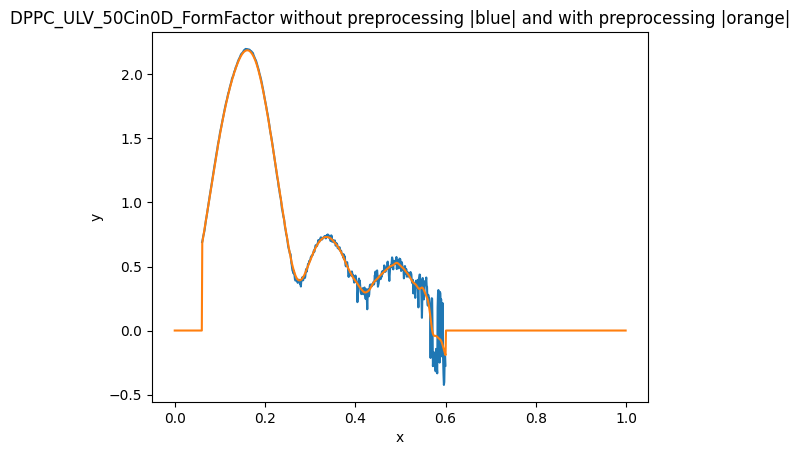

Predicted thickness:	 4.206432
  50% pred. interval:	(4.1365, 4.2158)
  75% pred. interval:	(4.0990, 4.2645)
  95% pred. interval:	(4.0345, 4.3513)

Predicted APL:		 65.175448
  50% pred. interval:	(63.1650, 64.4029)
  75% pred. interval:	(62.3835, 66.1822)
  95% pred. interval:	(60.5489, 68.9036)





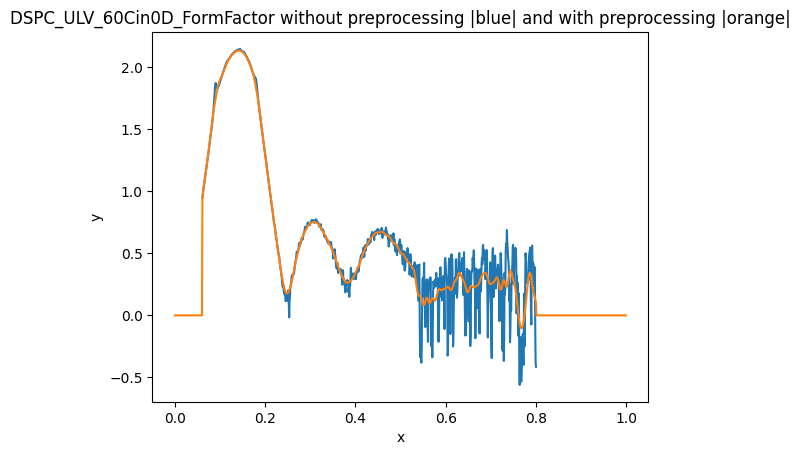

Predicted thickness:	 4.611770
  50% pred. interval:	(4.5408, 4.6316)
  75% pred. interval:	(4.4879, 4.6635)
  95% pred. interval:	(4.4077, 4.7265)

Predicted APL:		 59.839769
  50% pred. interval:	(59.1648, 60.8591)
  75% pred. interval:	(58.0213, 61.5778)
  95% pred. interval:	(56.4882, 63.2216)





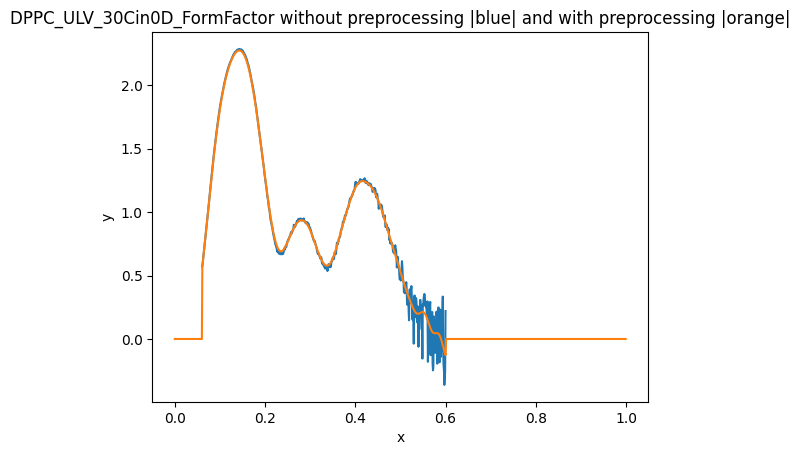

Predicted thickness:	 4.891140
  50% pred. interval:	(4.8902, 4.9680)
  75% pred. interval:	(4.8127, 5.0270)
  95% pred. interval:	(4.7303, 5.0966)

Predicted APL:		 53.797430
  50% pred. interval:	(52.7012, 53.8705)
  75% pred. interval:	(52.0519, 54.9950)
  95% pred. interval:	(50.1414, 56.6819)





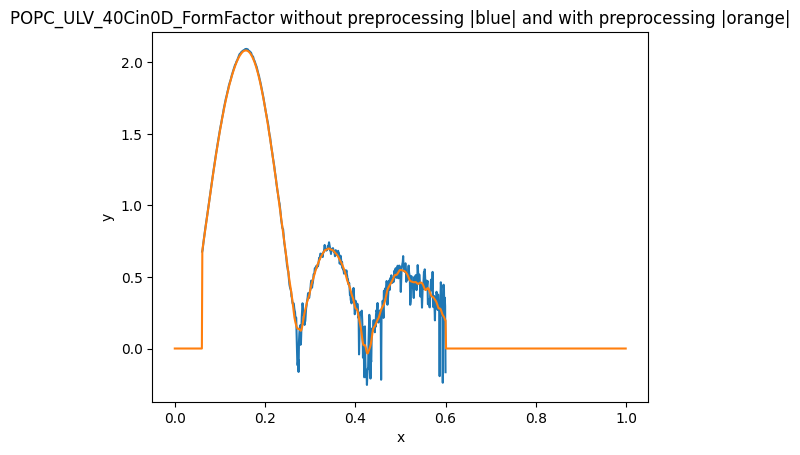

Predicted thickness:	 3.895289
  50% pred. interval:	(3.8493, 3.9267)
  75% pred. interval:	(3.8161, 3.9653)
  95% pred. interval:	(3.7490, 4.0393)

Predicted APL:		 66.210843
  50% pred. interval:	(65.0282, 66.3786)
  75% pred. interval:	(64.4509, 67.1110)
  95% pred. interval:	(62.3084, 68.8152)





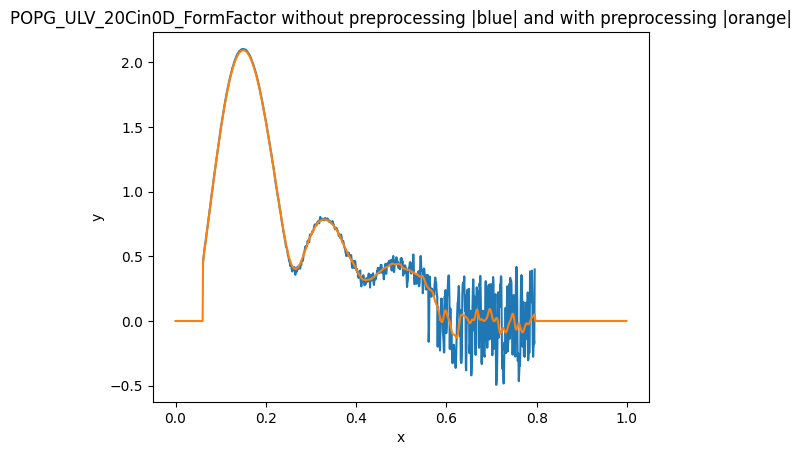

Predicted thickness:	 3.979243
  50% pred. interval:	(3.9507, 4.0401)
  75% pred. interval:	(3.8911, 4.0880)
  95% pred. interval:	(3.8327, 4.1654)

Predicted APL:		 64.157463
  50% pred. interval:	(61.7557, 63.3576)
  75% pred. interval:	(61.2664, 65.3039)
  95% pred. interval:	(59.4547, 68.0102)





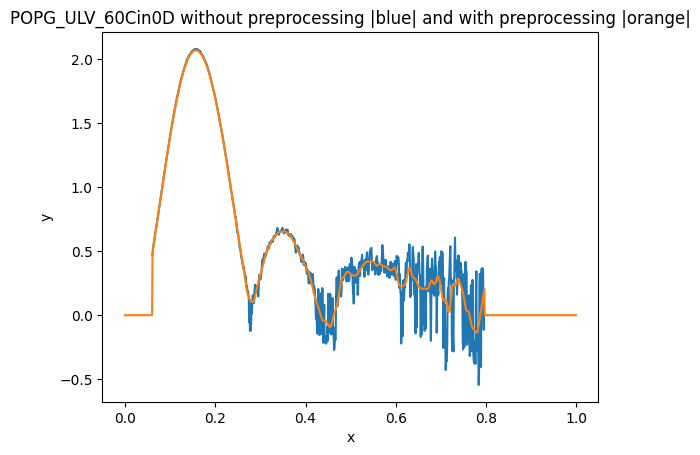

Predicted thickness:	 3.643591
  50% pred. interval:	(3.6271, 3.7073)
  75% pred. interval:	(3.5545, 3.7749)
  95% pred. interval:	(3.4906, 3.8430)

Predicted APL:		 70.033481
  50% pred. interval:	(70.3533, 71.6905)
  75% pred. interval:	(67.1255, 72.9841)
  95% pred. interval:	(65.5723, 74.3131)





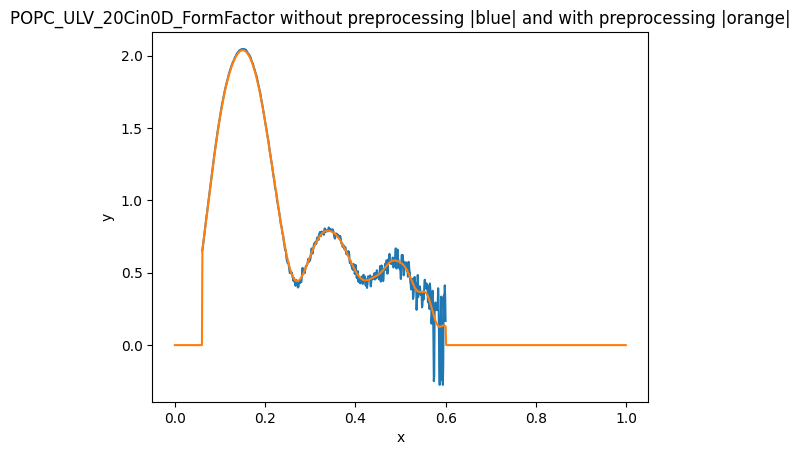

Predicted thickness:	 4.181463
  50% pred. interval:	(4.1634, 4.2386)
  75% pred. interval:	(4.0828, 4.2887)
  95% pred. interval:	(3.9960, 4.3631)

Predicted APL:		 56.990684
  50% pred. interval:	(53.9303, 55.1930)
  75% pred. interval:	(52.5828, 58.6410)
  95% pred. interval:	(51.0163, 61.6729)





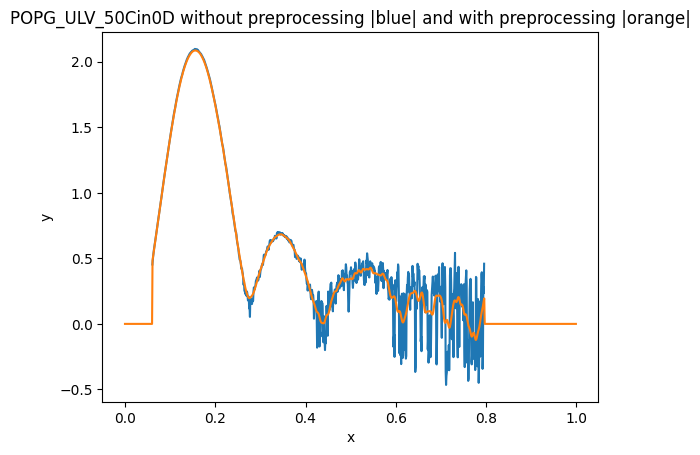

Predicted thickness:	 3.792448
  50% pred. interval:	(3.7531, 3.8202)
  75% pred. interval:	(3.6969, 3.8722)
  95% pred. interval:	(3.6358, 3.9355)

Predicted APL:		 71.274914
  50% pred. interval:	(71.1009, 72.6630)
  75% pred. interval:	(69.1829, 73.5247)
  95% pred. interval:	(67.4928, 74.9124)





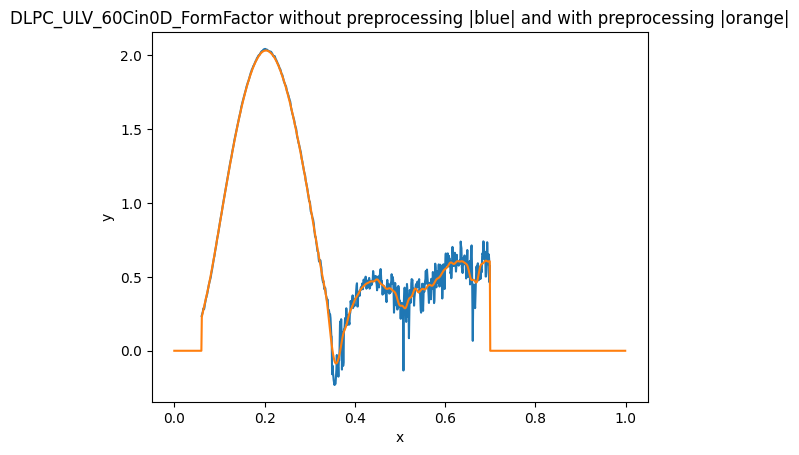

Predicted thickness:	 3.499970
  50% pred. interval:	(3.4633, 3.5380)
  75% pred. interval:	(3.4092, 3.6106)
  95% pred. interval:	(3.3401, 3.7588)

Predicted APL:		 61.656507
  50% pred. interval:	(60.7368, 62.0186)
  75% pred. interval:	(60.2204, 62.5996)
  95% pred. interval:	(58.1675, 64.4982)





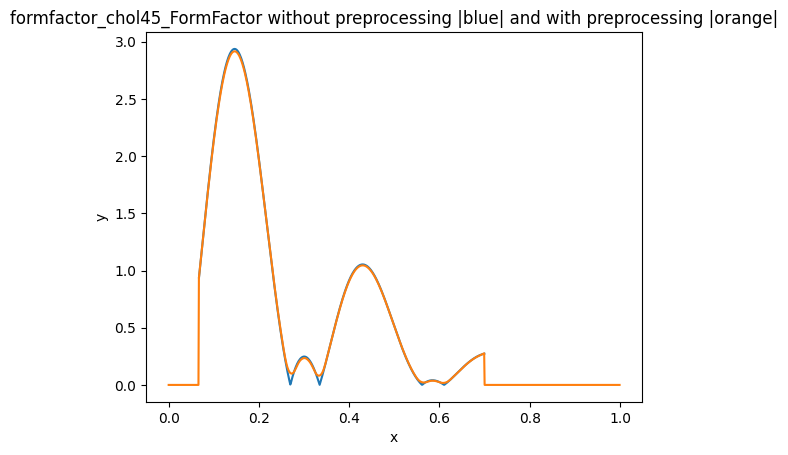

Predicted thickness:	 4.546051
  50% pred. interval:	(4.4966, 4.5970)
  75% pred. interval:	(4.4360, 4.6284)
  95% pred. interval:	(4.3751, 4.7125)

Predicted APL:		 55.470134
  50% pred. interval:	(54.4105, 55.6294)
  75% pred. interval:	(53.2165, 56.6058)
  95% pred. interval:	(51.5959, 58.2247)





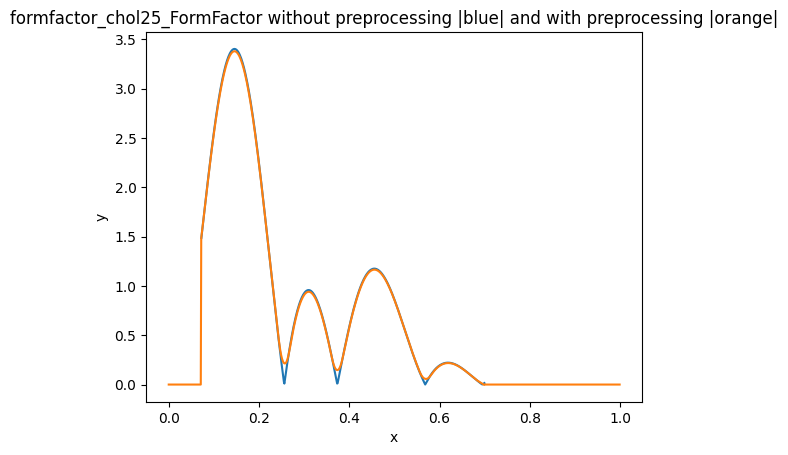

Predicted thickness:	 4.516553
  50% pred. interval:	(4.4343, 4.5112)
  75% pred. interval:	(4.4006, 4.5529)
  95% pred. interval:	(4.3384, 4.6381)

Predicted APL:		 57.261741
  50% pred. interval:	(55.6073, 56.9504)
  75% pred. interval:	(54.2199, 57.7000)
  95% pred. interval:	(52.5808, 59.3178)





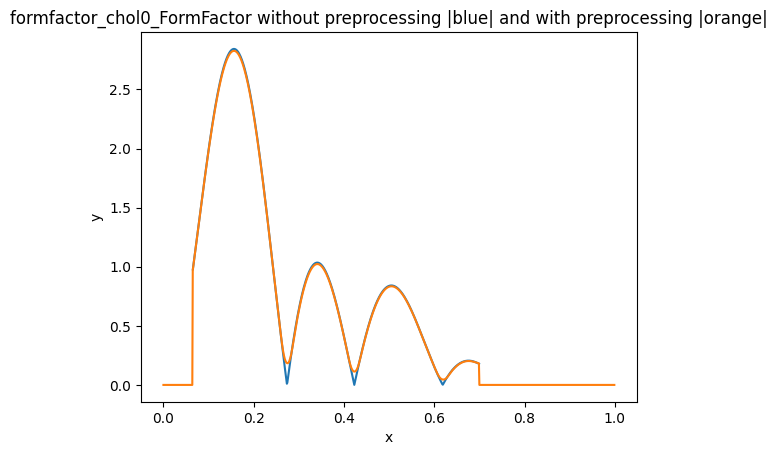

Predicted thickness:	 3.938756
  50% pred. interval:	(3.8903, 3.9645)
  75% pred. interval:	(3.8567, 4.0197)
  95% pred. interval:	(3.7888, 4.0840)

Predicted APL:		 67.994889
  50% pred. interval:	(67.5120, 68.7585)
  75% pred. interval:	(66.3271, 69.3837)
  95% pred. interval:	(64.6693, 70.9450)





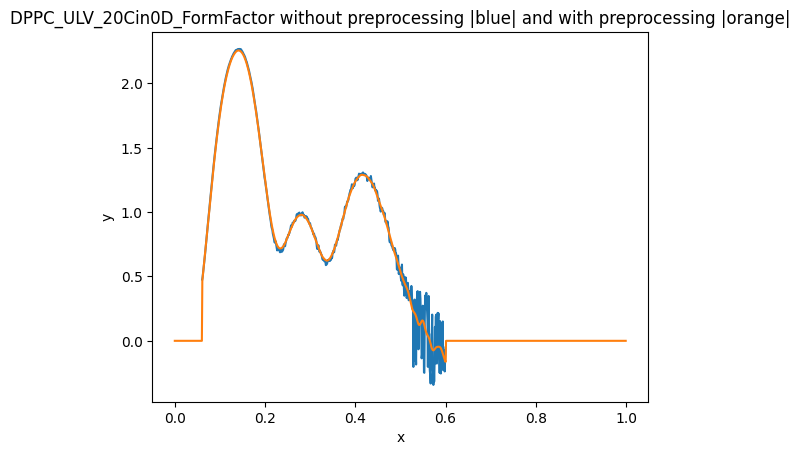

Predicted thickness:	 4.962804
  50% pred. interval:	(4.9726, 5.0488)
  75% pred. interval:	(4.8808, 5.1083)
  95% pred. interval:	(4.7906, 5.1805)

Predicted APL:		 54.537256
  50% pred. interval:	(53.5513, 54.7447)
  75% pred. interval:	(52.9295, 55.6266)
  95% pred. interval:	(50.9364, 57.5209)





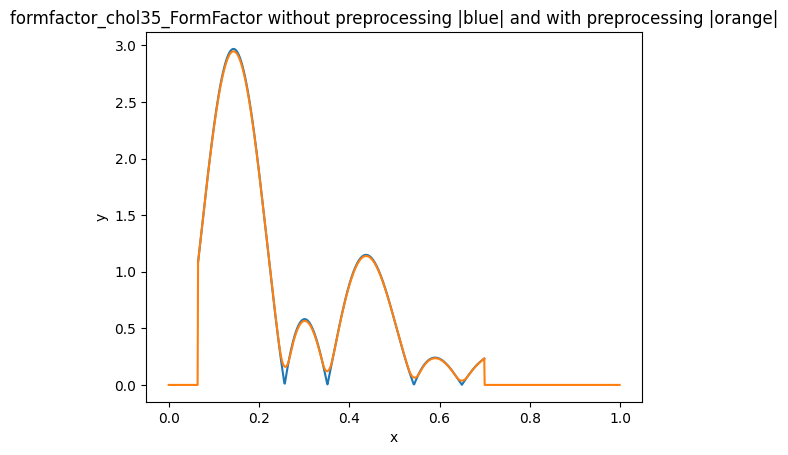

Predicted thickness:	 4.579604
  50% pred. interval:	(4.5241, 4.6050)
  75% pred. interval:	(4.4786, 4.6442)
  95% pred. interval:	(4.4117, 4.7309)

Predicted APL:		 55.129689
  50% pred. interval:	(53.4029, 54.8158)
  75% pred. interval:	(52.2817, 56.0758)
  95% pred. interval:	(50.6284, 57.5589)





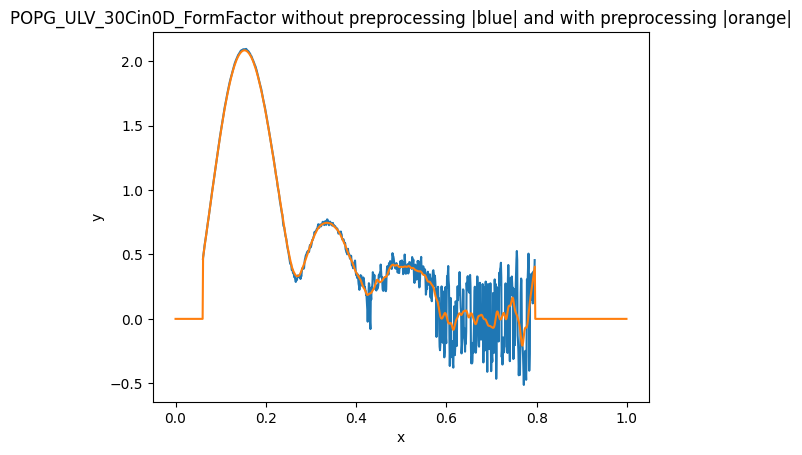

Predicted thickness:	 3.997008
  50% pred. interval:	(3.9790, 4.0454)
  75% pred. interval:	(3.9046, 4.0731)
  95% pred. interval:	(3.8400, 4.1444)

Predicted APL:		 66.631734
  50% pred. interval:	(64.4920, 65.9951)
  75% pred. interval:	(63.8698, 67.7522)
  95% pred. interval:	(62.0337, 69.3774)





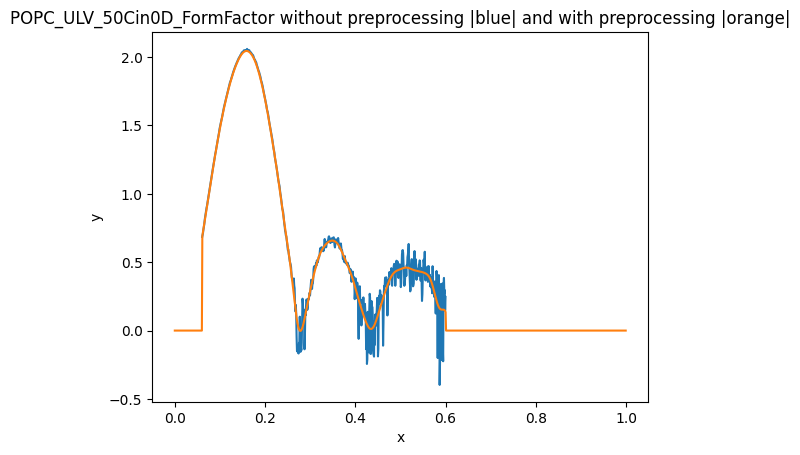

Predicted thickness:	 3.861971
  50% pred. interval:	(3.8133, 3.9003)
  75% pred. interval:	(3.7829, 3.9271)
  95% pred. interval:	(3.7161, 4.0085)

Predicted APL:		 67.331284
  50% pred. interval:	(66.7609, 68.1963)
  75% pred. interval:	(66.0740, 69.1511)
  95% pred. interval:	(64.3544, 70.8810)





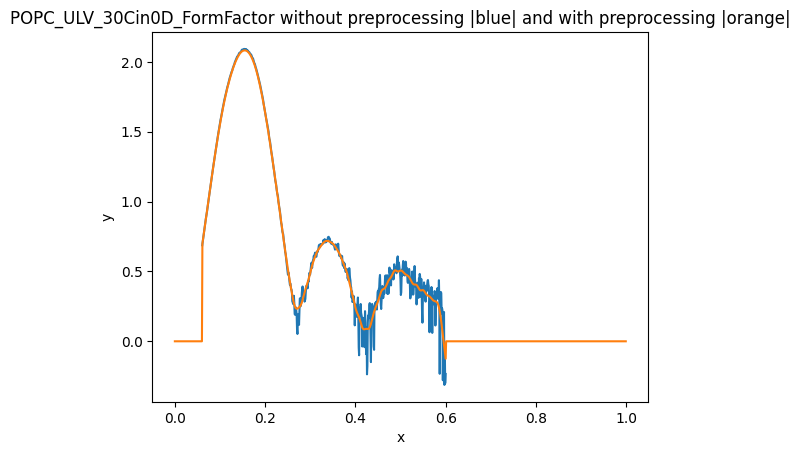

Predicted thickness:	 3.985783
  50% pred. interval:	(3.9372, 4.0172)
  75% pred. interval:	(3.8944, 4.0455)
  95% pred. interval:	(3.8327, 4.1235)

Predicted APL:		 66.110147
  50% pred. interval:	(64.7380, 66.2581)
  75% pred. interval:	(63.8594, 66.9806)
  95% pred. interval:	(61.9110, 68.5566)





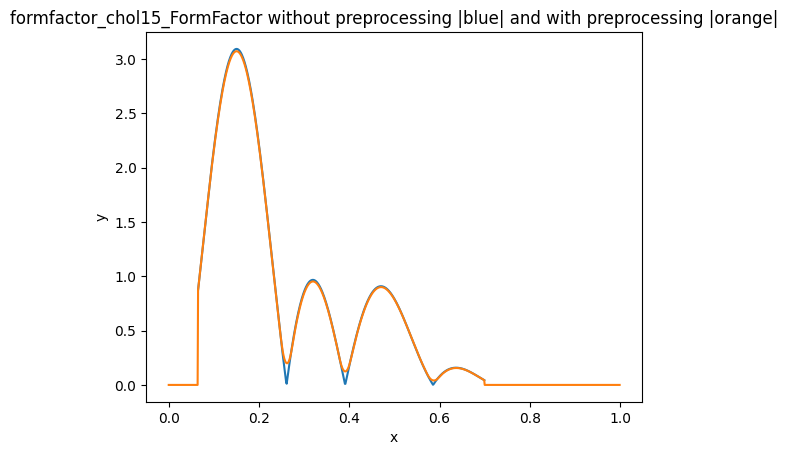

Predicted thickness:	 4.337487
  50% pred. interval:	(4.2615, 4.3457)
  75% pred. interval:	(4.2095, 4.4039)
  95% pred. interval:	(4.1458, 4.4880)

Predicted APL:		 61.310689
  50% pred. interval:	(60.0427, 61.3340)
  75% pred. interval:	(58.0814, 62.8677)
  95% pred. interval:	(56.4557, 64.2831)





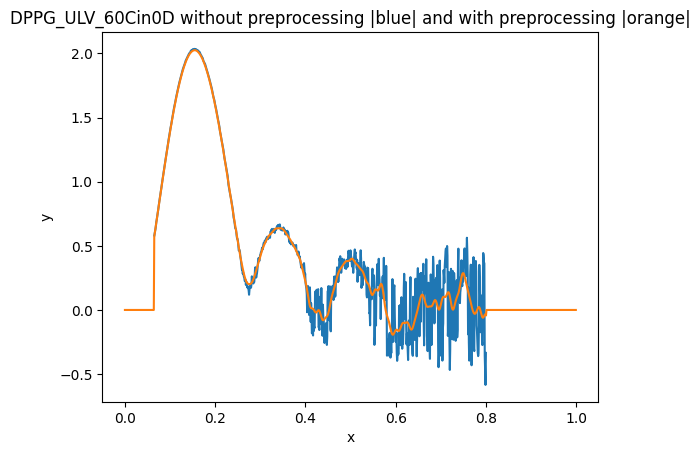

Predicted thickness:	 3.998387
  50% pred. interval:	(3.9549, 4.0292)
  75% pred. interval:	(3.8837, 4.0890)
  95% pred. interval:	(3.8010, 4.1593)

Predicted APL:		 72.838540
  50% pred. interval:	(73.0406, 74.1506)
  75% pred. interval:	(72.3616, 75.0631)
  95% pred. interval:	(70.7483, 76.9733)





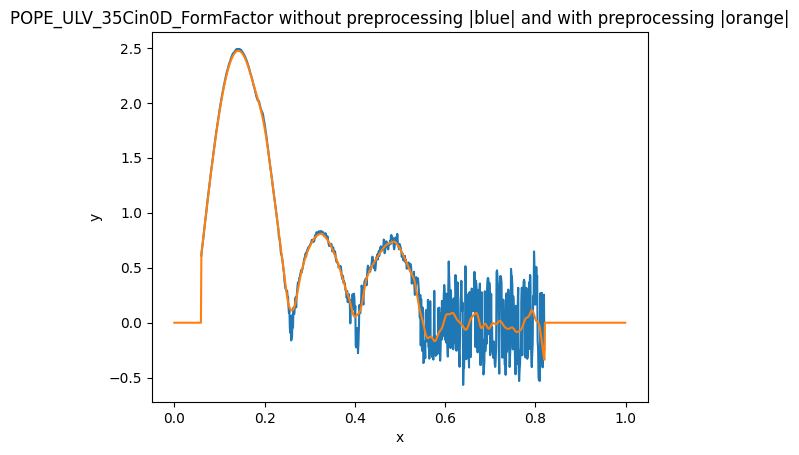

Predicted thickness:	 4.457865
  50% pred. interval:	(4.3925, 4.4743)
  75% pred. interval:	(4.3522, 4.5154)
  95% pred. interval:	(4.2659, 4.5824)

Predicted APL:		 63.724169
  50% pred. interval:	(62.3529, 63.4409)
  75% pred. interval:	(59.9802, 66.1510)
  95% pred. interval:	(58.4137, 67.6443)





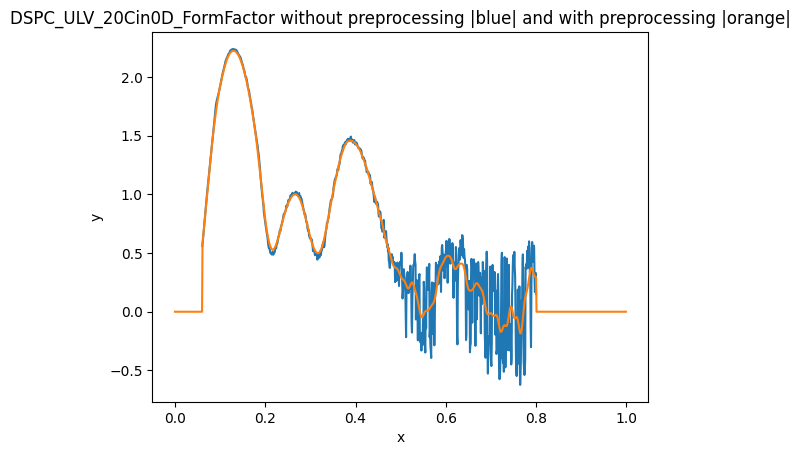

Predicted thickness:	 4.964136
  50% pred. interval:	(4.9816, 5.0538)
  75% pred. interval:	(4.8400, 5.1244)
  95% pred. interval:	(4.7497, 5.2095)

Predicted APL:		 55.077379
  50% pred. interval:	(54.6194, 55.8252)
  75% pred. interval:	(54.0424, 56.3897)
  95% pred. interval:	(52.1026, 58.2600)





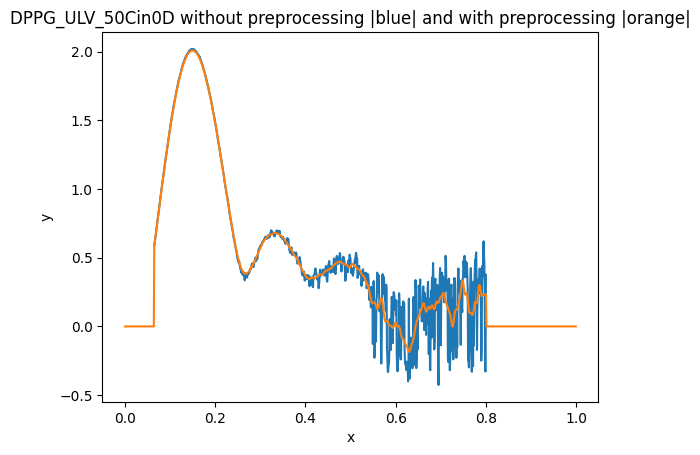

Predicted thickness:	 4.137054
  50% pred. interval:	(4.1080, 4.1792)
  75% pred. interval:	(4.0633, 4.2468)
  95% pred. interval:	(3.9763, 4.3177)

Predicted APL:		 68.349719
  50% pred. interval:	(66.5402, 67.8461)
  75% pred. interval:	(64.2621, 70.3233)
  95% pred. interval:	(62.5120, 72.8477)





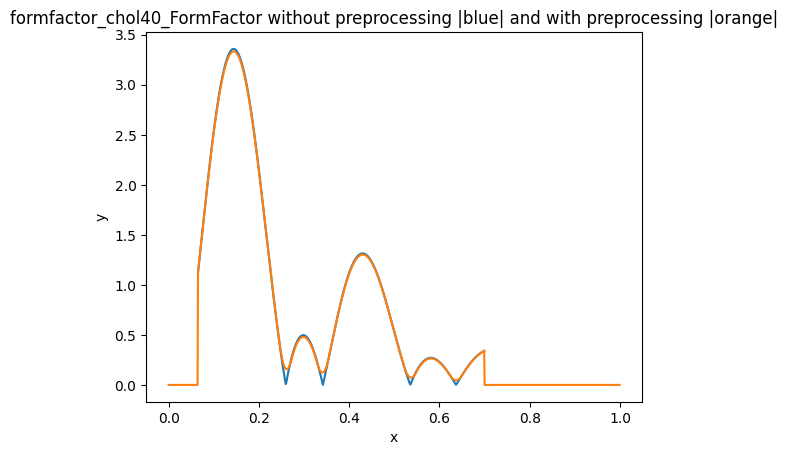

Predicted thickness:	 4.603386
  50% pred. interval:	(4.5504, 4.6434)
  75% pred. interval:	(4.5125, 4.6736)
  95% pred. interval:	(4.4473, 4.7566)

Predicted APL:		 54.205301
  50% pred. interval:	(52.8197, 53.9936)
  75% pred. interval:	(51.6450, 55.0519)
  95% pred. interval:	(50.0338, 56.6858)





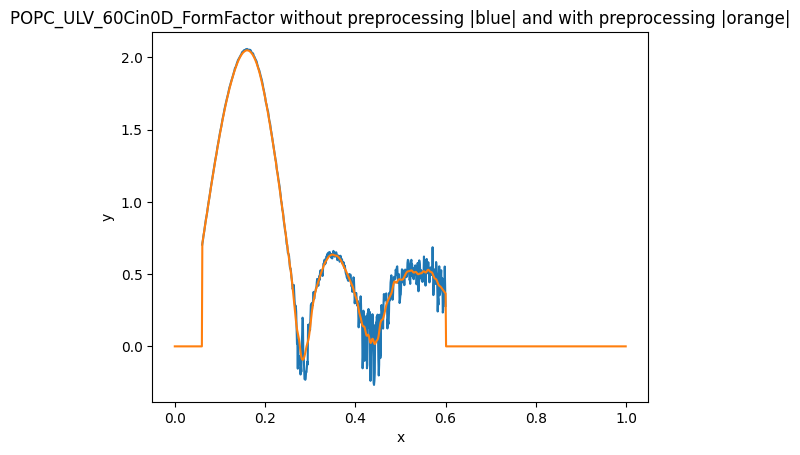

Predicted thickness:	 3.813410
  50% pred. interval:	(3.7776, 3.8443)
  75% pred. interval:	(3.7420, 3.8723)
  95% pred. interval:	(3.6641, 3.9503)

Predicted APL:		 65.058793
  50% pred. interval:	(64.4895, 65.6093)
  75% pred. interval:	(63.8973, 66.9838)
  95% pred. interval:	(61.9780, 68.5738)





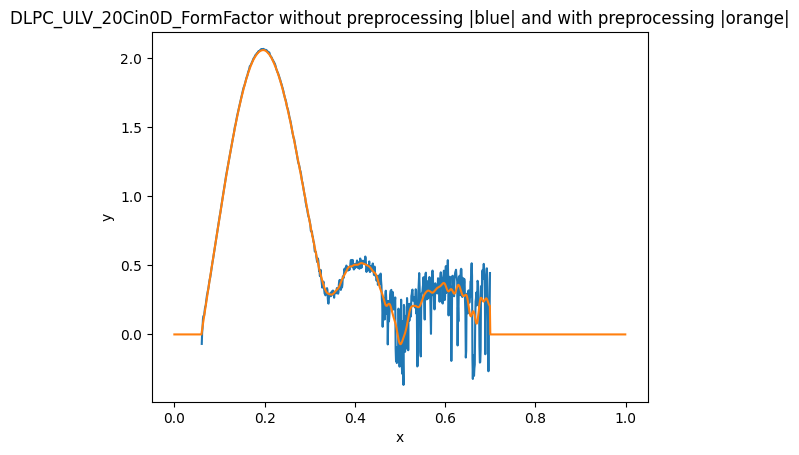

Predicted thickness:	 3.499749
  50% pred. interval:	(3.4550, 3.5209)
  75% pred. interval:	(3.4271, 3.5878)
  95% pred. interval:	(3.3637, 3.6815)

Predicted APL:		 63.557395
  50% pred. interval:	(62.9764, 64.0052)
  75% pred. interval:	(61.9781, 66.0102)
  95% pred. interval:	(60.3075, 67.4298)





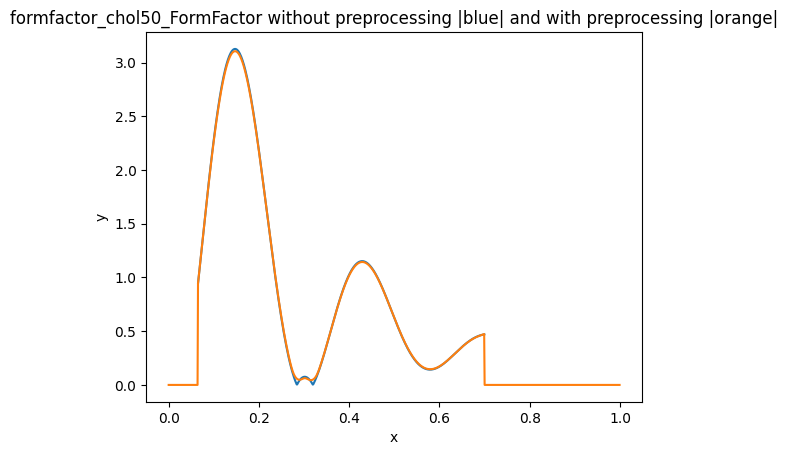

Predicted thickness:	 4.496125
  50% pred. interval:	(4.4628, 4.5573)
  75% pred. interval:	(4.3579, 4.5868)
  95% pred. interval:	(4.2978, 4.6663)

Predicted APL:		 56.508659
  50% pred. interval:	(55.4499, 56.8924)
  75% pred. interval:	(54.7309, 57.4338)
  95% pred. interval:	(52.7071, 59.2194)





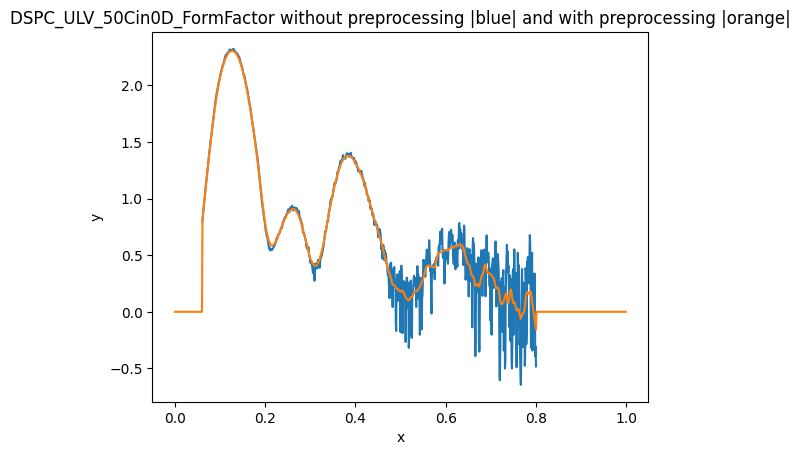

Predicted thickness:	 4.819799
  50% pred. interval:	(4.7957, 4.8666)
  75% pred. interval:	(4.6769, 4.9374)
  95% pred. interval:	(4.5655, 5.0153)

Predicted APL:		 54.718960
  50% pred. interval:	(54.3314, 55.4737)
  75% pred. interval:	(53.7114, 56.0115)
  95% pred. interval:	(51.8423, 57.9017)





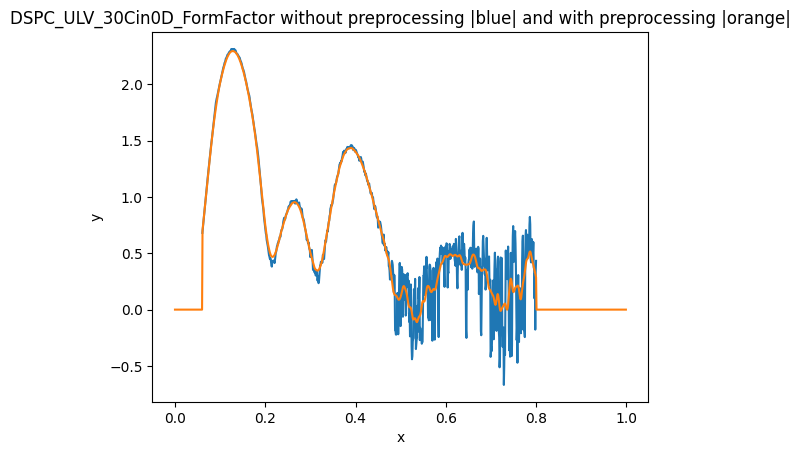

Predicted thickness:	 4.777444
  50% pred. interval:	(4.8076, 4.8860)
  75% pred. interval:	(4.6602, 4.9380)
  95% pred. interval:	(4.5686, 5.0066)

Predicted APL:		 54.612277
  50% pred. interval:	(54.2193, 55.4178)
  75% pred. interval:	(53.5972, 55.9842)
  95% pred. interval:	(51.7180, 57.9315)





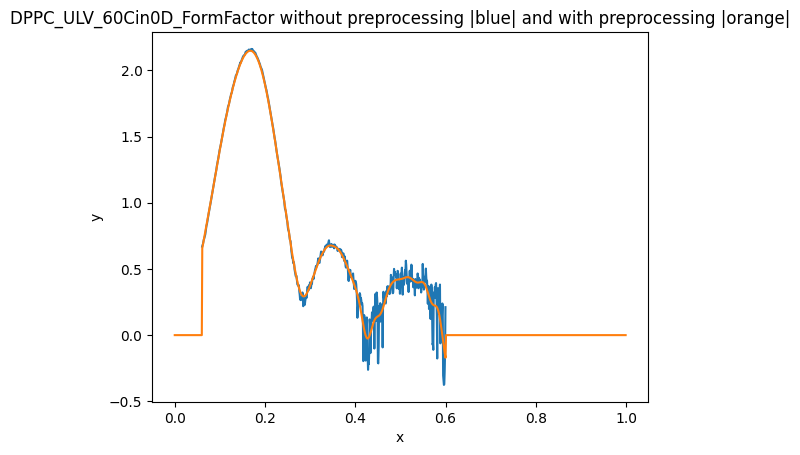

Predicted thickness:	 3.893930
  50% pred. interval:	(3.8470, 3.9155)
  75% pred. interval:	(3.8153, 3.9452)
  95% pred. interval:	(3.7493, 4.0321)

Predicted APL:		 67.722038
  50% pred. interval:	(66.5581, 67.7823)
  75% pred. interval:	(65.9714, 68.4222)
  95% pred. interval:	(64.0263, 70.3179)





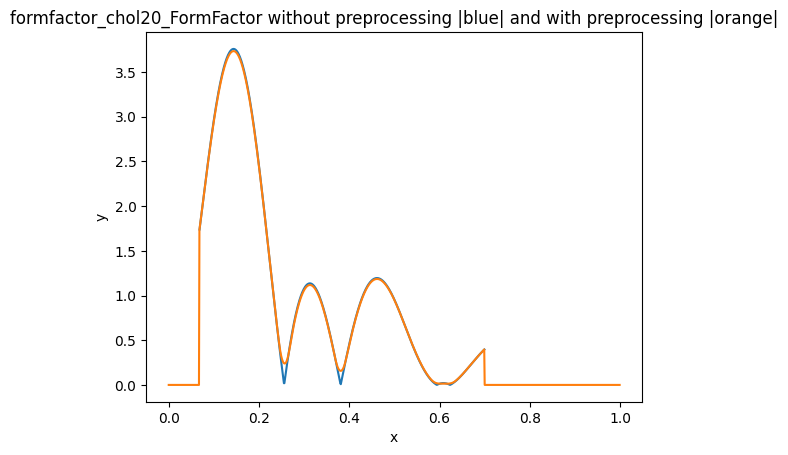

Predicted thickness:	 4.390867
  50% pred. interval:	(4.3249, 4.4061)
  75% pred. interval:	(4.2918, 4.4493)
  95% pred. interval:	(4.2236, 4.5351)

Predicted APL:		 57.860032
  50% pred. interval:	(56.8573, 58.3497)
  75% pred. interval:	(55.4949, 59.0446)
  95% pred. interval:	(53.8804, 60.6097)





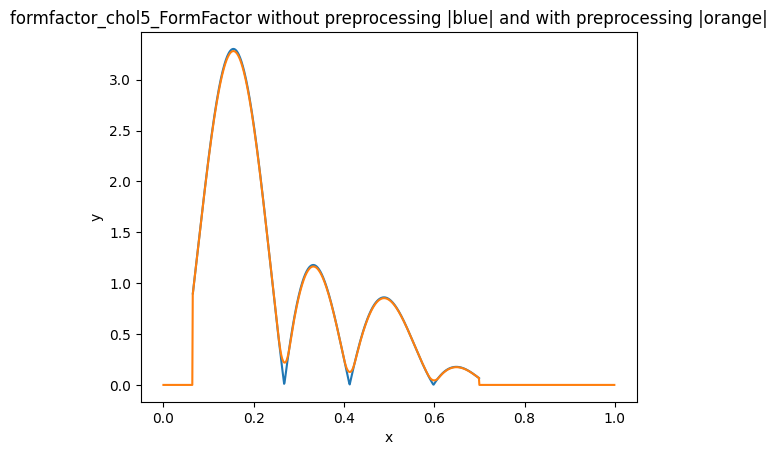

Predicted thickness:	 4.140904
  50% pred. interval:	(4.0810, 4.1624)
  75% pred. interval:	(4.0408, 4.1890)
  95% pred. interval:	(3.9771, 4.2691)

Predicted APL:		 67.172350
  50% pred. interval:	(66.1688, 67.7902)
  75% pred. interval:	(65.5445, 68.7210)
  95% pred. interval:	(63.5472, 70.2798)





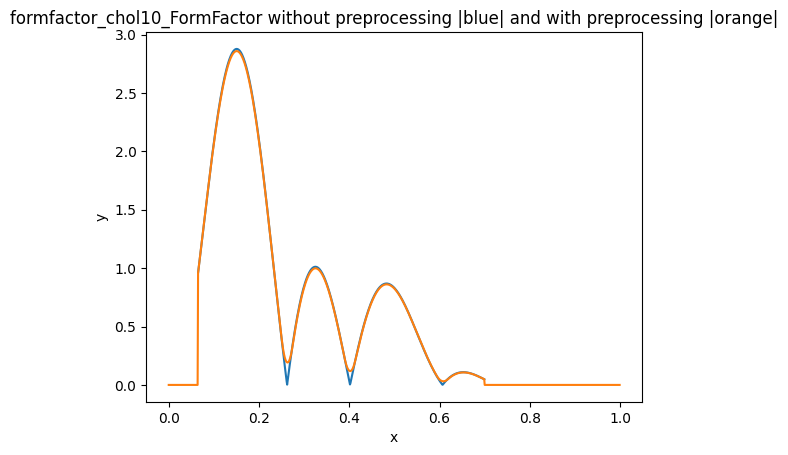

Predicted thickness:	 4.171603
  50% pred. interval:	(4.1096, 4.2109)
  75% pred. interval:	(4.0745, 4.2394)
  95% pred. interval:	(4.0059, 4.3210)

Predicted APL:		 62.157052
  50% pred. interval:	(60.7084, 62.1278)
  75% pred. interval:	(59.1738, 63.3377)
  95% pred. interval:	(57.6131, 64.8286)





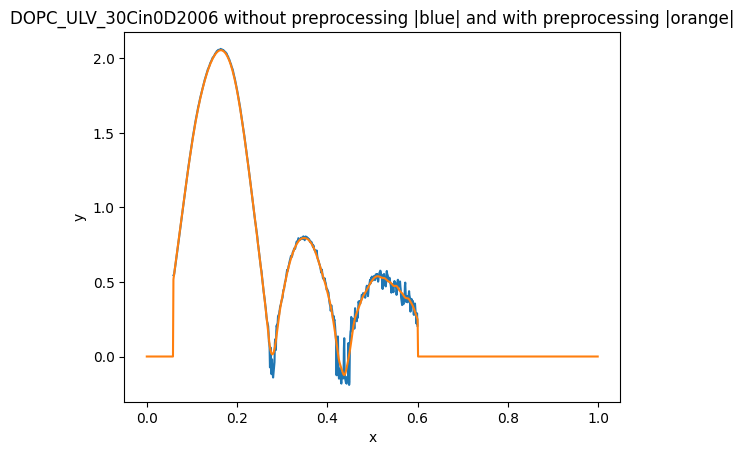

Predicted thickness:	 3.878268
  50% pred. interval:	(3.8461, 3.9188)
  75% pred. interval:	(3.8145, 3.9472)
  95% pred. interval:	(3.7465, 4.0238)

Predicted APL:		 65.034572
  50% pred. interval:	(64.5201, 66.0320)
  75% pred. interval:	(63.2326, 66.6601)
  95% pred. interval:	(61.6705, 68.5122)





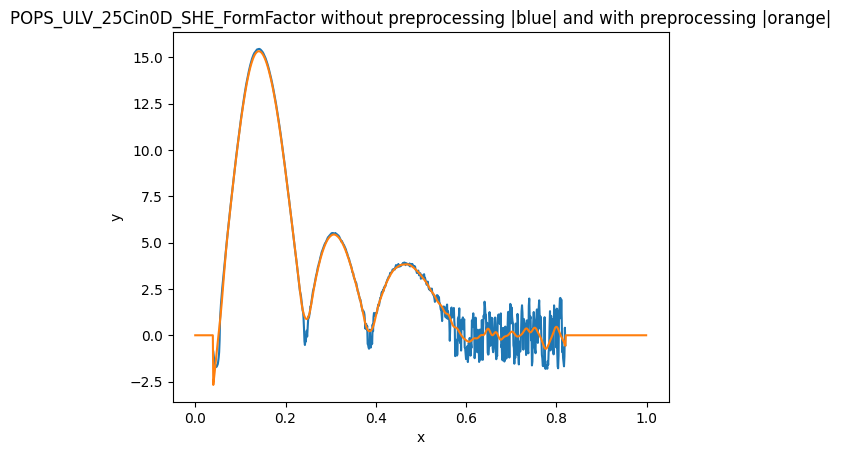

Predicted thickness:	 4.373783
  50% pred. interval:	(4.2952, 4.3791)
  75% pred. interval:	(4.2679, 4.4380)
  95% pred. interval:	(4.2013, 4.5150)

Predicted APL:		 58.593372
  50% pred. interval:	(57.3036, 58.5863)
  75% pred. interval:	(55.8161, 59.1423)
  95% pred. interval:	(54.1722, 60.8431)





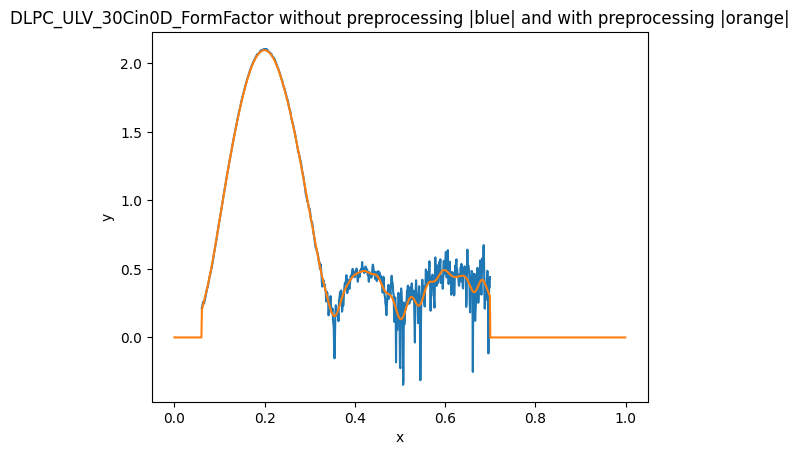

Predicted thickness:	 3.440760
  50% pred. interval:	(3.4002, 3.4707)
  75% pred. interval:	(3.3693, 3.5479)
  95% pred. interval:	(3.3045, 3.6650)

Predicted APL:		 63.570683
  50% pred. interval:	(62.6837, 63.8151)
  75% pred. interval:	(61.9061, 65.1910)
  95% pred. interval:	(60.1694, 66.7487)





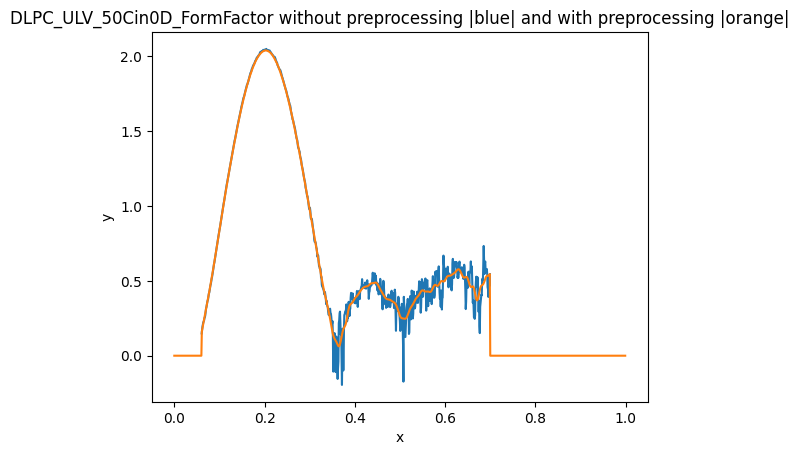

Predicted thickness:	 3.477649
  50% pred. interval:	(3.4271, 3.5041)
  75% pred. interval:	(3.3906, 3.5799)
  95% pred. interval:	(3.3240, 3.7360)

Predicted APL:		 62.657393
  50% pred. interval:	(61.6798, 62.9281)
  75% pred. interval:	(61.1145, 63.5907)
  95% pred. interval:	(59.1655, 65.3847)





In [3]:
thickness_preds = []
apl_preds = []

csp = CellScatterPredictor()

for i, column in enumerate(exp_FF.columns):
    preprocessed_ff = exp_FF_list[i]
    
    plt.plot(exp_FF.iloc[0, i], exp_FF.iloc[1, i])
    plt.plot(np.arange(0, 1, 0.001), preprocessed_ff)
    plt.title(column + ' without preprocessing |blue| and with preprocessing |orange|')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
    thickness_preds.append(csp.predict_thickness(preprocessed_ff, constant_normalization=False))
    apl_preds.append(csp.predict_apl(preprocessed_ff, constant_normalization=False))
    
    print("\n")

While the predictions don't seem clearly off, there is no real way to evaluate these predictions, since the real values aren't available. While we already know that the models perform very well on the simulated data, performance on the experimental data need further evaluation. The amount of experimental data is also small enough that it's hard to draw conclusions form the predictions' distribuiton.

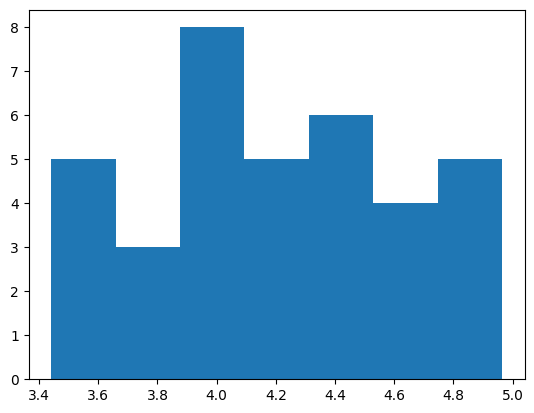

[3.440760426785078, 3.4776492455832715, 3.499748718166038, 3.4999702910915698, 3.6435906187422096, 3.792448072119913, 3.8134103355749, 3.8619705383741727, 3.87826795053597, 3.893930282733249, 3.8952892351435535, 3.938755952974182, 3.979242658184798, 3.9857825053901115, 3.997008499781946, 3.9983867888815063, 4.13705420535392, 4.140903950084955, 4.171602752287644, 4.181462883887708, 4.2064316294360085, 4.337487498253564, 4.373782731563533, 4.390867216252966, 4.457864950625584, 4.49612477271261, 4.516552920757886, 4.5460507626556215, 4.57960437594276, 4.603385821862771, 4.61176956830515, 4.777444310854014, 4.819799299923946, 4.891139569862399, 4.962804259233328, 4.964135948231069]


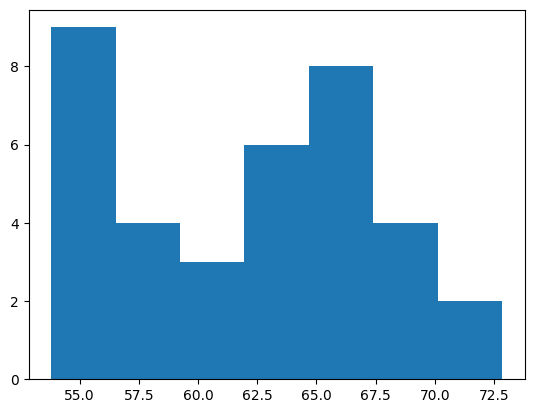

[53.79743023890477, 54.20530057605356, 54.53725594303418, 54.61227693704664, 54.71895998186467, 55.07737875732576, 55.129688799525006, 55.47013446279039, 56.508659273225646, 56.99068411967085, 57.26174122580989, 57.86003229976453, 58.59337208317133, 59.83976910463797, 61.31068875676711, 61.65650721260451, 62.15705211812906, 62.65739276906179, 63.5573948922422, 63.57068318408094, 63.724169348291504, 64.15746307159242, 65.0345716255818, 65.05879325167872, 65.17544846961368, 66.1101474658721, 66.21084274557055, 66.6317340638297, 67.1723501789837, 67.33128351092819, 67.72203823412397, 67.99488850352122, 68.34971875128831, 70.03348055285832, 71.27491376287922, 72.83854016198114]


In [4]:
plt.hist(thickness_preds, bins=7)
plt.show()

print(sorted(thickness_preds))

plt.hist(apl_preds, bins=7)
plt.show()

print(sorted(apl_preds))